<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S7/ERA_S7_C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model5().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
         Dropout2d-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
         Dropout2d-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 10, 10, 10]             910
       BatchNorm2d-9           [-1, 10, 10, 10]              20
        Dropout2d-10           [-1, 10, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,456
      BatchNorm2d-12             [-1, 16, 8, 8]              32

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

In [ ]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
model = Model5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2, verbose=True)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 0


Loss=0.058750879019498825 Batch_id=468 Accuracy=89.78: 100%|██████████| 469/469 [00:47<00:00,  9.91it/s]



Test set: Average loss: 0.0671, Accuracy: 9811/10000 (98.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 1


Loss=0.1338837742805481 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:43<00:00, 10.80it/s]



Test set: Average loss: 0.0403, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 2


Loss=0.0265397559851408 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 3


Loss=0.04951426014304161 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 2.0000e-03.
EPOCH: 4


Loss=0.07022816687822342 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 2.0000e-03.
EPOCH: 5


Loss=0.1069483831524849 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 2.0000e-03.
EPOCH: 6


Loss=0.0258879866451025 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]



Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 2.0000e-03.
EPOCH: 7


Loss=0.0655321404337883 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s]



Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 4.0000e-04.
EPOCH: 8


Loss=0.026357628405094147 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:43<00:00, 10.86it/s]



Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 4.0000e-04.
EPOCH: 9


Loss=0.05655844509601593 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 4.0000e-04.
EPOCH: 10


Loss=0.03197348117828369 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:43<00:00, 10.91it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 4.0000e-04.
EPOCH: 11


Loss=0.0274738147854805 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:44<00:00, 10.47it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 8.0000e-05.
EPOCH: 12


Loss=0.10467994958162308 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 8.0000e-05.
EPOCH: 13


Loss=0.02873358689248562 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:42<00:00, 10.97it/s]



Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 8.0000e-05.
EPOCH: 14


Loss=0.07498975843191147 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:45<00:00, 10.36it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 8.0000e-05.


Text(0.5, 1.0, 'Test Accuracy')

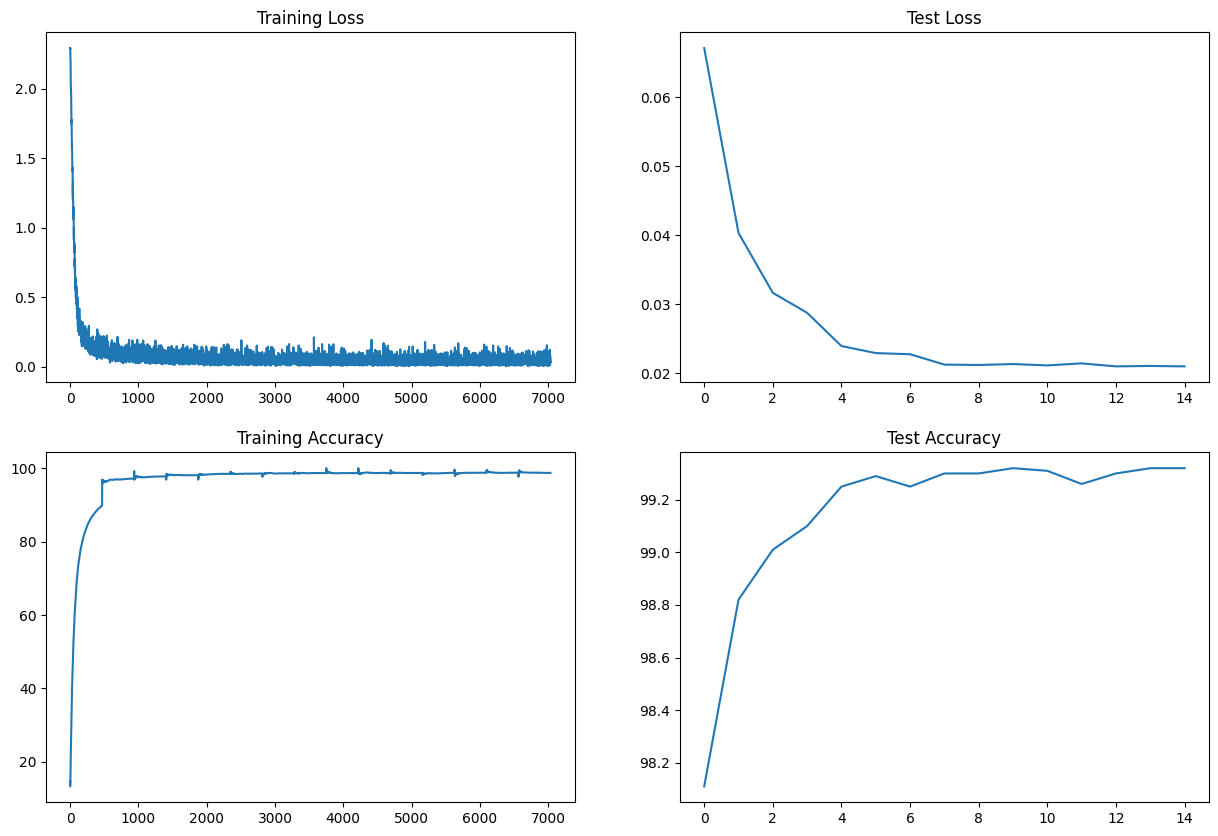

In [ ]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**


1.   Introduce BN, lower the batch size and increase LR along with a schedule



**Result:**

1.   Parameter: 8,342
2.   Best Training Accuracy: 98.79
3.   Best Test Accuracy: 99.32


**Analysis:**


1.   Need to improve the training accuracy, no overfitting. Might need to change the structure of the model
